# Engenharia de Dados com Python e Postgres e Análise com PowerBI

## Bibliotecas

In [ ]:
# Instalando a biblioteca faker
!pip install faker

In [ ]:
# Instalando a biblioteca do sgbd Postgres
!pip install psycopg2

In [ ]:
# Instalando a biblioteca folium
!pip install folium

In [ ]:
# Instalando a biblioteca geopy
!pip install geopy

In [288]:
import pandas as pd
import numpy as np
from faker import Faker
import psycopg2
from psycopg2.extensions import AsIs
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from geopy.geocoders import Nominatim
from IPython.display import display

## Funções

> A função **`ler_arquivo_excel()`** cria um único objeto no formato ***DataFrame*** chamado **`planilha_unificada`**, o parâmetro **`arquivo=`** recebe o nome do arquivo da base de dados, já no parâmetro **`nome_tabela=`** recebe uma *tupla* contendo os nomes das tabelas internas do arquivo excel.

In [2]:
def ler_arquivo_excel(arquivo:'FilePath', nome_tabela:tuple) -> 'DataFrame':
    planilha_1 = pd.read_excel(arquivo, sheet_name=nome_tabela[0])
    planilha_2 = pd.read_excel(arquivo, sheet_name=nome_tabela[1])
    
    planilha_unificada = pd.concat([planilha_1, planilha_2])
    
    return planilha_unificada

> A função **`transforma_dados()`** rotorna o obejto ***DataFrame*** **`'dados'`**, após realizar as transformações de renomea as colunas, criar coluna Total_vendido e remove os valores NaN. O parâmetro **`dados_base=`** recebe o objeto ***DataFrame*** para realizar as transformações na base de dados.

In [3]:
def transforma_dados(dados_base:'DataFrame') -> 'DataFrame':
    # Renomea colunas.
    dados = dados_base.rename(columns={
        'StockCode': 'Id_produto',
        'Description': 'Produto',
        'Quantity': 'Quantidade',
        'InvoiceDate': 'Data',
        'Price': 'Preço',
        'Customer ID': 'Id_cliente',
        'Country': 'Localização'
    })
    
    # Cria coluna Total Vendido.
    dados['Total_vendido'] = dados['Quantidade'] * dados['Preço']
    
    # Remove valores nulos.
    dados = dados.dropna()
    
    # Alterando os valores negativos das notas canceladas para 0
    dados.loc[dados['Invoice'].str.contains('C'), ['Quantidade', 'Preço', 'Total_vendido']] = 0
    
    # Excluindo linhas com id_produto igual a TEST
    dados.drop(dados[dados['Id_produto'].str.contains('TEST')].index, inplace=True)
    
    return dados

> A função **`cria_tabela_clientes()`** rotorna um novo obejto ***DataFrame*** **`clientes`**, após realizar seleção das colunas ***Id_cliente e Localização***, os dados recebem um completmento de informações usando a biblioteca ***Faker***, que será usado para gerar nomes e emails, para os clientes e complementar os dados na tabela, por fim, o ***DataFrame*** é estruturado e  suas colunas são ordenadas. O parâmetro **`dados_base=`** recebe o objeto ***DataFrame*** da base de dados já tradata.

In [4]:
def cria_tabela_clientes(dados_base:'DataFrame') -> 'DataFrame':
    # Criando copia da base original.
    dados_copia = dados_base.copy()
    clientes_original = dados_copia[['Id_cliente', 'Localização']]
    clientes = clientes_original.copy()

    # Removendo Ids duplicados.
    clientes.drop_duplicates(
        subset=['Id_cliente'],
        keep='first',
        inplace=True
    )
    
    # Convertando Ids para inteiro.
    clientes['Id_cliente'] = clientes['Id_cliente'].astype(int)

    # Ordenando coluna ids.
    clientes = clientes.sort_values(
        by='Id_cliente',
        ascending=True
    )
    
    # Definindo uma semente para a função Faker.
    Faker.seed(10)
    faker = Faker()

    # Criando lista de nomes.
    nomes_clientes = []
    while len(nomes_clientes) < len(clientes):
        nome_cliente = faker.company()
        if nome_cliente not in nomes_clientes:
            nomes_clientes.append(nome_cliente)

    # Criando emails.
    emails = []
    for name in nomes_clientes:
        email = name.replace(",", "").lower() + "@email.com"
        email = email.replace(" ", "")
        emails.append(email)

    clientes['Cliente'] = nomes_clientes
    clientes['Email'] = emails
    ordem_colunas = ['Id_cliente', 'Cliente', 'Email', 'Localização']
    clientes = clientes.reindex(columns=ordem_colunas)    

    return clientes


> A função **`cria_tabela_vendas()`** rotorna um novo obejto ***DataFrame*** **`vendas`**, realiza a seleção das colunas ***Invoice, Id_cliente, Data e Total_vendido***, a coluna ***Id_cliente*** é convertida para inteiro e a coluna ***Data*** para o formato datetime, por fim a tabela é agrupada pela coluna ***Total_vendido*** e ordenada pela coluna ***Invoice***. O parâmetro **`dados_base=`** recebe o objeto ***DataFrame*** da base de dados já tradata.

In [5]:
def cria_tabela_vendas(dados_base:'DataFrame') -> 'DataFrame':
    # Criando copia da base original.
    dados_copia = dados.copy()
    vendas_original = dados_copia[['Invoice', 'Id_cliente', 'Data', 'Total_vendido']]
    vendas = vendas_original.copy()
    
    # Transformando coluna Id_cliente em inteiro.
    vendas['Id_cliente'] = vendas['Id_cliente'].astype(int)

    # Convertendo data
    vendas['Data'] = vendas['Data'].dt.date
    vendas['Data'] = pd.to_datetime(vendas['Data'])

    # Agrupando vendas pelo total das vendas.
    vendas = vendas.groupby(['Invoice', 'Id_cliente', 'Data'])['Total_vendido'].sum().reset_index()

    vendas = vendas.sort_values('Invoice', ascending=True)

    return vendas

> A função **`cria_tabela_produto()`** rotorna um novo obejto ***DataFrame*** **`produtos`**, realiza a seleção das colunas ***Id_produto, Produto e Preço***, remove as duplicidades apartir da coluna ***Id_produto*** e ordenada a tabela pela coluna ***Id_produto***. O parâmetro **`dados_base=`** recebe o objeto ***DataFrame*** da base de dados já tradata.

In [6]:
def cria_tabela_produto(dados_base:'DataFrame') -> 'DataFrame':
    # Criando copia da base original.
    dados_copia = dados.copy()
    produtos_original = dados_copia[['Id_produto', 'Produto', 'Preço']]
    produtos = produtos_original.copy()

    # Removendo duplicidades.
    produtos.drop_duplicates(
        subset=['Id_produto'],
        keep='first',
        inplace=True
    )

    produtos['Id_produto'] = produtos['Id_produto'].astype(str)
    produtos = produtos.sort_values('Id_produto', ascending=True)

    return produtos

> A função **`cria_tabela_itens_venda()`** rotorna um novo obejto ***DataFrame*** **`itens_venda`**, realiza a seleção das colunas ***Invoice, Id_produto, Quantidade, Preço e Total_vendido***, remove os produtos duplicados apartir da coluna ***Id_produto*** e por fim ordenada a tabela. O parâmetro **`dados_base=`** recebe o objeto ***DataFrame*** da base de dados já tradata.

In [7]:
def cria_tabela_itens_venda(dados_base:'DataFrame') -> 'DataFrame':
    # Criando copia da base original.
    dados_copia = dados.copy()
    itens_venda = dados_copia[['Invoice', 'Id_produto', 'Quantidade', 'Preço', 'Total_vendido']]

    # Removendo produtos duplicados.
    itens_venda = itens_venda.groupby(['Invoice','Id_produto']).agg({
        'Quantidade':   'sum',
        'Preço':      'first',
        'Total_vendido': 'sum'
    }).reset_index()
    
    ordem_coluna = ['Invoice', 'Id_produto', 'Quantidade', 'Preço', 'Total_vendido']
    itens_venda = itens_venda.reindex(columns=ordem_coluna)

    return itens_venda

> A função **`conecta_db_postgres()`** recebe no parâmetro **`banco_dados=`** uma tupla com os dados de acesso ao banco de dados, e retorna uma tupla com o *conector* e *cursor* do banco de dados.

In [8]:
def conecta_db_postgres(acesso:tuple) -> tuple:
    # Conectando ao SGBD.
    conn = psycopg2.connect(host=acesso[0],
                            database=acesso[1],
                            user=acesso[2],
                            password=acesso[3])

    # Commit automatico.
    conn.autocommit = True

    cursor = conn.cursor()

    return conn, cursor

>  A função **`finaliza_conexao_postgres()`** recebe o *conector* no parâmetro **`conn=`** e o *cursor* no parâmetro **`cursor=`**, e assim realiza o fim da conexão com o banco de dados.

In [9]:
def finaliza_conexao_postgres(cursor:'cursor', conn:'connection') -> None:
    cursor.close()
    conn.close()

    return None

> A função **`cria_db()`** recebe uma tupla com os dados de acesso no parâmetro **`banco_dados=`** e uma string no parâmetro **`novo_banco_dados=`**, a função realiza a criação de um novo banco de dados no PostgreSQL.

In [10]:
def cria_db(banco_dados:tuple, novo_banco_dados:str) -> None:
    conn, cursor = conecta_db_postgres(acesso=banco_dados)

    cursor.execute("SELECT datname FROM pg_database WHERE datname = %s", (novo_banco_dados,))
    row = cursor.fetchall()

    if row:
        print(f'ATENÇÃO: Banco de dados {novo_banco_dados} já existe!')
    else:
        cursor.execute("CREATE DATABASE %s;", (AsIs(novo_banco_dados),))
        print(f'Banco de dados {novo_banco_dados} criado!')

    finaliza_conexao_postgres(cursor=cursor, conn=conn)

    return None

> A função **`cria_schema_db()`**, no parâmetro **`banco_dados=`**, recebe uma tupla com dados de acesso do banco, e no parâmetro **`novo_schema=`**, recebe uma string com o nome do schema, o resultado é a criação de um novo schema no banco de dados.

In [11]:
def cria_schema_db(banco_dados:tuple, novo_schema:str) -> None:
    conn, cursor = conecta_db_postgres(acesso=banco_dados)

    cursor.execute("SELECT schema_name FROM information_schema.schemata WHERE schema_name = %s", (novo_schema,))
    row = cursor.fetchall()

    if row:
        print(f'ATENÇÃO: Schema {novo_schema} já existe!')
    else:
        cursor.execute("CREATE SCHEMA %s;", (AsIs(novo_schema),))
        print(f'SCHEMA {novo_schema} criado!')

    finaliza_conexao_postgres(cursor=cursor, conn=conn)

    return None

> A função **`cria_tabelas_banco_dados_relacional()`** recebe os parâmetros **`banco_dados=tuple, schema=str, nova_tabela=str, colunas_tabela=list, tabela_dados=DataFrame, query_cria_tabela=str, query_inseri_dados=str e numero_linhas=int`**, para criar uma nova tabela em um banco de dados e inserir dados na tabela, o retorno da função é uma tupla com a consulta de n linhas e suas dimensões.

In [12]:
def cria_tabelas_banco_dados_relacional(banco_dados:tuple, schema:str, nova_tabela:str, colunas_tabela:list,
                                        tabela_dados:'DataFrame', query_cria_tabela:str, query_inseri_dados:str,
                                        numero_linhas:int) -> tuple:
    
    conn, cursor = conecta_db_postgres(acesso=banco_dados)

    cursor.execute("""SELECT EXISTS (SELECT *
                      FROM information_schema.tables
                      WHERE table_schema = %s AND table_name = %s );""", (schema, nova_tabela,))
    tabela_existe = cursor.fetchone()[0]
    
    if tabela_existe:
        print(f'ATENÇÃO: A tabela {nova_tabela} já existe!')
        
        cursor.execute("""SELECT * FROM %s.%s;""", (AsIs(schema,), AsIs(nova_tabela,),))
        rows = cursor.fetchall()
        consulta_sql = pd.DataFrame(rows, columns=colunas_tabela)
        
    else:
        print(f"Tabela {nova_tabela} criada!")

        cursor.execute(query_cria_tabela)
        
        lista = tuple(tabela_dados.values)
        for linha in lista:
            cursor.execute(query_inseri_dados, linha)
        
        cursor.execute("""SELECT * FROM %s.%s;""",(AsIs(schema,), AsIs(nova_tabela,),))
        rows = cursor.fetchall()
        consulta_sql = pd.DataFrame(rows, columns=colunas_tabela)
        
    finaliza_conexao_postgres(cursor, conn)

    return consulta_sql.head(numero_linhas), consulta_sql.shape

> A função **`cria_tabelas_banco_dados_dimensional()`** recebe os parâmetros **`banco_dados=tuple, schema=str, nova_tabela=str, colunas_tabela=list, query_cria_tabela=str, query_inseri_dados=str e numero_linhas=int`**, para criar uma nova tabela em um banco de dados e inserir dados na tabela, o retorno da função é uma tupla com a consulta de n linhas e suas dimensões.

In [13]:
def cria_tabelas_banco_dados_dimensional(banco_dados:tuple, schema:str, nova_tabela:str, colunas_tabela:list,
                                         query_cria_tabela:str, query_inseri_dados:str, numero_linhas:int) -> tuple:

    conn, cursor = conecta_db_postgres(acesso=banco_dados)
    
    cursor.execute("""SELECT EXISTS (SELECT *
                      FROM information_schema.tables
                      WHERE table_schema = %s AND table_name = %s );""", (schema, nova_tabela,))
    tabela_existe = cursor.fetchone()[0]
    
    if tabela_existe:
        print(f'ATENÇÃO: A tabela {nova_tabela} já existe!')
        
        cursor.execute("""SELECT * FROM %s.%s;""", (AsIs(schema,), AsIs(nova_tabela,),))
        rows = cursor.fetchall()
        consulta_sql = pd.DataFrame(rows, columns=colunas_tabela)
        
    else:
        print(f"Tabela {nova_tabela} criada!")
        
        cursor.execute(query_cria_tabela)
        cursor.execute(query_inseri_dados)
        cursor.execute("""SELECT * FROM %s.%s;""",(AsIs(schema,), AsIs(nova_tabela,),))
        rows = cursor.fetchall()
        consulta_sql = pd.DataFrame(rows, columns=colunas_tabela)
        
    finaliza_conexao_postgres(cursor, conn)

    return consulta_sql.head(numero_linhas), consulta_sql.shape

> A função **`consulta_sql()`** recebe o acesso ao banco de dados em uma tupla no parâmetro **`banco_dados=`**, o parâmetro **`query=`** recebe uma query SQL no formato de string e o parâmetro **`colunas=`** recebe uma lista com o nome das colunas, que será usado no *DataFrame* que é o retorno da função.

In [185]:
def consulta_sql(banco_dados:tuple, query:str, colunas:list) -> 'DataFrame':
    conn, cursor = conecta_db_postgres(acesso=banco_dados)

    cursor.execute(query)
    rows = cursor.fetchall()
    consulta = pd.DataFrame(rows, columns=colunas)

    finaliza_conexao_postgres(cursor, conn)
    
    return consulta

> A função **`grafico_pizza()`** recebe um *DataFrame* no parâmetro **`dados=`** e retorna um gráfico de pizza.

In [113]:
def grafico_pizza(dados:'DataFrame') -> None:
    # Criar rótulos personalizados com o ano e o valor do faturamento.
    labels = [f"{ano}: $ {faturamento:,.2f}" for ano,
              faturamento in zip(dados['Ano'], dados['Faturamento'])]

    f, ax = plt.subplots(figsize=(8, 8))
    ax.pie(dados['Faturamento'], autopct='%1.1f%%', pctdistance=1.1, labeldistance=1.5,
           wedgeprops=dict(width=0.30), colors=['#6E1423', '#A11D33', '#E01E37'])
    plt.legend(labels=labels, title='Ano e Faturamento',
               loc='center', prop={'size': 10})
    plt.title('Faturamento Anual')
    plt.show()

    return None


> A função **`grafico_barras()`** recebe no parâmetro **`dados=`** um *DataFrame* com os dados e no parâmetro **`config_grafico=`** recebe uam tupla com os dados de configuração do gráfico.

In [222]:
def grafico_barras(dados:'DataFrame', config_grafico:tuple) -> None:
    plt.figure(figsize=(12, 6))
    sns.barplot(x=dados[config_grafico[2]],
                y=dados[config_grafico[3]],
                orient=config_grafico[1],
                palette='flare')
    
    plt.ylabel(config_grafico[3])
    plt.xlabel(config_grafico[2])
    plt.title(config_grafico[0])
    plt.show()

    return None

> A função **`grafico_mapa()`** recebe no parâmetro **`dados=`** um *DataFrame* com os dados e no parâmetro **`zoom=`** recebe um inteiro referente ao zoom do mapa.

In [309]:
def grafico_mapa(dados:'DataFrame', zoom:int) -> None:
    # Coordenadas base para o centro do mapa.
    latitude_centro = 55.3781
    longitude_centro = 3.4360

    # Cria o mapa com base nas coordenadas do centro.
    mapa = folium.Map(location=[latitude_centro, longitude_centro],
                      zoom_start=zoom,
                      tiles = 'cartodbpositron',
                      prefer_canvas=True)

    # Função para obter as coordenadas geográficas dos países.
    def obter_coordenadas(pais):
        geolocator = Nominatim(user_agent="mapa_de_vendas")
        location = geolocator.geocode(pais)
        if location:
            return location.latitude, location.longitude
        else:
            return None

    # Adiciona marcadores para cada país.
    for indice, linha in dados.iterrows():
        pais = linha['pais']
        vendas = linha['vendas']
        coordenadas = obter_coordenadas(pais)
        if coordenadas:
            popup_text = (f"País:{pais}<br>Vendas:{vendas}")
            folium.Marker(coordenadas, popup=popup_text, 
                          icon=folium.Icon(color='red',
                          icon='ok-sign'), tooltip=pais).add_to(mapa)

    # Exibe o mapa
    display(mapa)

    return None

## Carregando e Tratando os Dados

- Os passos para essa primeira faze:

     - Carregando dados da base excel para um DataFrame.
     - Transfomando dados, removendo valores nulos, renomeando colunas e criando coluna Total_vendido. 
     - Tratamento de dados inconsistente, valores negativos referente a Invoice cancelados.

### Carga dos dados

In [14]:
# Acessando planilhas excel
base_original = './Base_de_dados_original/online_retail_II.xlsx'
abas = 'Year 2009-2010', 'Year 2010-2011'
dados = ler_arquivo_excel(arquivo=base_original, nome_tabela=abas)

# Visualizando as 10 primeiras linhas
dados.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


In [15]:
# Dimesões da base de dados original
dados.shape

(1067371, 8)

### Verificando dados inconsistentes e  Dados nulos

In [ ]:
# Colunas do dataframe
dados.columns

In [16]:
# Verificando nulos
dados.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [17]:
# Transformando coluna 'Invoice' em string
dados['Invoice'] = dados['Invoice'].astype(str)

# Verificando notas canceladas
dados[dados['Invoice'].str.contains('C')]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [18]:
# Transformando coluna 'Id_produto' em string
dados['StockCode'] = dados['StockCode'].astype(str)

# Verificando produtos TEST
dados[dados['StockCode'].str.contains('TEST')]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
27994,491725,TEST001,This is a test product.,10,2009-12-14 08:34:00,4.5,12346.0,United Kingdom
28251,491742,TEST001,This is a test product.,5,2009-12-14 11:00:00,4.5,12346.0,United Kingdom
28254,491744,TEST001,This is a test product.,5,2009-12-14 11:02:00,4.5,12346.0,United Kingdom
39398,492718,TEST001,This is a test product.,5,2009-12-18 10:47:00,4.5,12346.0,United Kingdom
39411,492722,TEST002,This is a test product.,1,2009-12-18 10:55:00,1.0,12346.0,United Kingdom
44614,493294,TEST002,NaN,1,2009-12-22 15:15:00,0.0,NaN,United Kingdom
45228,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.5,12346.0,United Kingdom
45230,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.5,12346.0,United Kingdom
56117,494450,TEST001,This is a test product.,5,2010-01-14 13:50:00,4.5,12346.0,United Kingdom
66084,495295,TEST001,This is a test product.,5,2010-01-22 13:30:00,4.5,12346.0,United Kingdom


### Transformando os dados

In [19]:
# Transformação da base de dados
dados = transforma_dados(dados)

In [ ]:
# Colunas do dataframe
dados.columns

In [20]:
# Verificando nulos
dados.isnull().sum()

Invoice          0
Id_produto       0
Produto          0
Quantidade       0
Data             0
Preço            0
Id_cliente       0
Localização      0
Total_vendido    0
dtype: int64

In [21]:
# Verificando alterações
dados[dados['Invoice'].str.contains('C')]

,Invoice,Id_produto,Produto,Quantidade,Data,Preço,Id_cliente,Localização,Total_vendido
178,C489449,22087,PAPER BUNTING WHITE LACE,0,2009-12-01 10:33:00,0.0,16321.0,Australia,0.0
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,0,2009-12-01 10:33:00,0.0,16321.0,Australia,0.0
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,0,2009-12-01 10:33:00,0.0,16321.0,Australia,0.0
181,C489449,21896,POTTING SHED TWINE,0,2009-12-01 10:33:00,0.0,16321.0,Australia,0.0
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,0,2009-12-01 10:33:00,0.0,16321.0,Australia,0.0
...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,0,2011-12-09 09:57:00,0.0,14397.0,United Kingdom,0.0
541541,C581499,M,Manual,0,2011-12-09 10:28:00,0.0,15498.0,United Kingdom,0.0
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,0,2011-12-09 11:57:00,0.0,15311.0,United Kingdom,0.0
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,0,2011-12-09 11:58:00,0.0,17315.0,United Kingdom,0.0


In [22]:
# Verificando produtos TEST
dados[dados['Id_produto'].str.contains('TEST')]

,Invoice,Id_produto,Produto,Quantidade,Data,Preço,Id_cliente,Localização,Total_vendido


In [23]:
# Visualizando base de dados final
dados.head(10)

,Invoice,Id_produto,Produto,Quantidade,Data,Preço,Id_cliente,Localização,Total_vendido
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom,39.6
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom,59.5
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom,30.6
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom,45.0


In [24]:
# Dimensões da base de dados
dados.shape

(824335, 9)

In [25]:
# Verificando valores únicos
dados.nunique()

Invoice          44860
Id_produto        4644
Produto           5298
Quantidade         439
Data             41425
Preço              666
Id_cliente        5940
Localização         41
Total_vendido     3920
dtype: int64

## Preparando Dados para Carga no DB Relacional

- Os dados receberão uma nova transformação, afim de eliminar duplicidades e serão separados em tabelas:
     - clientes.
     - vendas.
     - produtos.
     - itens venda.

### Tabela clientes

In [26]:
# Criando tabela Clientes
clientes = cria_tabela_clientes(dados_base=dados)

In [27]:
# Visualizando lista de clientes completa
# ID, Nome, Email e localização
clientes.head(10)

,Id_cliente,Cliente,Email,Localização
71080,12346,"Johnson, Olson and Smith",johnsonolsonandsmith@email.com,United Kingdom
423892,12347,Li-Colon,li-colon@email.com,Iceland
358167,12348,"Cochran, Johnson and Henry",cochranjohnsonandhenry@email.com,Finland
10837,12349,Wright Ltd,wrightltd@email.com,Italy
80323,12350,Williams-Dalton,williams-dalton@email.com,Norway
499199,12351,"Kelly, Fisher and Serrano",kellyfisherandserrano@email.com,Unspecified
453366,12352,Bryant-Jennings,bryant-jennings@email.com,Norway
417341,12353,"Cox, Bryant and Dalton",coxbryantanddalton@email.com,Bahrain
166267,12354,Montes PLC,montesplc@email.com,Spain
206105,12355,Williams-Smith,williams-smith@email.com,Bahrain


In [28]:
# Dimensões da tabela clientes
clientes.shape

(5940, 4)

### Tabela vendas

In [29]:
# Criando tabela Vendas
vendas = cria_tabela_vendas(dados)

In [30]:
# Visualizando lista de vendas completa
# Invoice, Id_cliente, Data e Total_vendido
vendas.head(10)

,Invoice,Id_cliente,Data,Total_vendido
0,489434,13085,2009-12-01,505.30
1,489435,13085,2009-12-01,145.80
2,489436,13078,2009-12-01,630.33
3,489437,15362,2009-12-01,310.75
4,489438,18102,2009-12-01,2286.24
5,489439,12682,2009-12-01,426.30
6,489440,18087,2009-12-01,50.40
7,489441,18087,2009-12-01,344.34
8,489442,13635,2009-12-01,382.37
9,489443,14110,2009-12-01,285.06


In [31]:
# Dimensões da tabela vendas
vendas.shape

(44860, 4)

### Tabela produtos

In [32]:
# Criando tabela Produto
produtos = cria_tabela_produto(dados)

In [33]:
# Visualizando tabela produtos
# Id_produto, Produto, Preço
produtos.head(10)

,Id_produto,Produto,Preço
41,10002,INFLATABLE POLITICAL GLOBE,0.85
6339,10080,GROOVY CACTUS INFLATABLE,0.85
7218,10109,BENDY COLOUR PENCILS,0.42
2944,10120,DOGGY RUBBER,0.21
11727,10123C,HEARTS WRAPPING TAPE,0.65
273353,10123G,ARMY CAMO WRAPPING TAPE,0.65
130361,10124A,SPOTS ON RED BOOKCOVER TAPE,0.42
203252,10124G,ARMY CAMO BOOKCOVER TAPE,0.42
3106,10125,MINI FUNKY DESIGN TAPES,0.85
475,10133,COLOURING PENCILS BROWN TUBE,0.85


In [34]:
# Dimensões da tabela produtos
produtos.shape

(4644, 3)

### Tabela itens venda

In [35]:
# Criando tabela Itens Vendidos
itens_venda = cria_tabela_itens_venda(dados)

In [36]:
# Verificando tabela itens venda
# Invoice, Id_produto, Quantidade, Preço, Total_vendido
itens_venda.head(10)

,Invoice,Id_produto,Quantidade,Preço,Total_vendido
0,489434,21232,24,1.25,30.0
1,489434,21523,10,5.95,59.5
2,489434,21871,24,1.25,30.0
3,489434,22041,48,2.10,100.8
4,489434,22064,24,1.65,39.6
5,489434,79323P,12,6.75,81.0
6,489434,79323W,12,6.75,81.0
7,489434,85048,12,6.95,83.4
8,489435,22195,24,1.65,39.6
9,489435,22349,12,3.75,45.0


In [37]:
# Dimensões da tabela itens vendida
itens_venda.shape

(787164, 5)

# Criando DB Relacional - PostgreSQL

> Um banco de dados relacional é um tipo de sistema de gerenciamento de banco de dados (DBMS) que organiza e armazena dados em tabelas com estruturas bem definidas. Ele é chamado de "relacional" porque estabelece relações entre os dados armazenados em diferentes tabelas. Essas relações são definidas por meio de chaves primárias e estrangeiras, que permitem que os dados sejam relacionados e consultados de maneira eficiente.

*Schema Banco de dados Relacional.*

<img src='./schema_database_postgres/Schema-Relacional.png'>

## Criando Database e Schema

In [38]:
# Variáveis de acesso
acesso_postgres = ('localhost','postgres','postgres','123456')
acesso_wgift = ('localhost','wgift','postgres','123456')
schema_relacional = 'relacional'

# Criando banco de dados
cria_db(banco_dados=acesso_postgres, novo_banco_dados=acesso_wgift[1])

# Criando schema
cria_schema_db(banco_dados=acesso_wgift, novo_schema=schema_relacional)

Banco de dados wgift criado!
SCHEMA relacional criado!


## Criando Tabelas e Inserindo Dados

### Criando Tabela Relacional Clientes

In [39]:
# Variável do nome da tabela
tabela_clientes = 'clientes'

# Variável com as colunas do DataFrame
colunas_clientes_relacional = ['Id_cliente', 'Cliente', 'Email', 'Localizacao']

# Query de criação de uma tabela
query_tabela_clientes_relacional = """
            CREATE TABLE relacional.clientes(
            Id_cliente  INT PRIMARY KEY NOT NULL,
            Cliente     VARCHAR(300) NOT NULL,
            Email       VARCHAR(300) NOT NULL,
            Localizacao VARCHAR(255) NOT NULL);"""

# Query para inserir dados na tabela
query_inseri_dados_clientes_relacional = """
                INSERT INTO relacional.clientes (id_cliente, cliente, email, localizacao)
                VALUES (%s, %s, %s, %s);"""

In [40]:
# Executando função que cria tabela em um banco de dados e popula tabela com DataFrame
cria_tabelas_banco_dados_relacional(banco_dados=acesso_wgift, schema=schema_relacional, nova_tabela=tabela_clientes,
                                    colunas_tabela=colunas_clientes_relacional, tabela_dados=clientes,
                                    query_cria_tabela=query_tabela_clientes_relacional,
                                    query_inseri_dados=query_inseri_dados_clientes_relacional, numero_linhas=10)

Tabela clientes criada!


(   Id_cliente                     Cliente                             Email  \
 0       12346    Johnson, Olson and Smith    johnsonolsonandsmith@email.com   
 1       12347                    Li-Colon                li-colon@email.com   
 2       12348  Cochran, Johnson and Henry  cochranjohnsonandhenry@email.com   
 3       12349                  Wright Ltd               wrightltd@email.com   
 4       12350             Williams-Dalton         williams-dalton@email.com   
 5       12351   Kelly, Fisher and Serrano   kellyfisherandserrano@email.com   
 6       12352             Bryant-Jennings         bryant-jennings@email.com   
 7       12353      Cox, Bryant and Dalton      coxbryantanddalton@email.com   
 8       12354                  Montes PLC               montesplc@email.com   
 9       12355              Williams-Smith          williams-smith@email.com   
 
       Localizacao  
 0  United Kingdom  
 1         Iceland  
 2         Finland  
 3           Italy  
 4          N

### Criando Tabela Relacional Vendas

In [41]:
# Variável do nome da tabela
tabela_vendas = 'vendas'

# Variável com as colunas do DataFrame
colunas_vendas_relacional = ['Invoice', 'Id_cliente', 'Data', 'Total_vendido']

# Query de criação de uma tabela
query_tabela_vendas_relacional = """
            CREATE TABLE relacional.vendas(
            Invoice       VARCHAR(15) PRIMARY KEY NOT NULL,
            Id_cliente    INT references relacional.clientes (id_cliente) ON DELETE RESTRICT,
            Data          DATE NOT NULL,
            Total_vendido DECIMAL(10,2) NOT NULL);"""

# Query para inserir dados na tabela
query_inseri_dados_vendas_relacional = """
                INSERT INTO relacional.vendas (invoice, id_cliente, data, total_vendido)
                VALUES (%s, %s, %s, %s);"""

In [42]:
# Executando função que cria tabela em um banco de dados e popula tabela com DataFrame
cria_tabelas_banco_dados_relacional(banco_dados=acesso_wgift, schema=schema_relacional, nova_tabela=tabela_vendas,
                        colunas_tabela=colunas_vendas_relacional, tabela_dados=vendas,
                        query_cria_tabela=query_tabela_vendas_relacional,
                        query_inseri_dados=query_inseri_dados_vendas_relacional, numero_linhas=10)

Tabela vendas criada!


(  Invoice  Id_cliente        Data Total_vendido
 0  489434       13085  2009-12-01        505.30
 1  489435       13085  2009-12-01        145.80
 2  489436       13078  2009-12-01        630.33
 3  489437       15362  2009-12-01        310.75
 4  489438       18102  2009-12-01       2286.24
 5  489439       12682  2009-12-01        426.30
 6  489440       18087  2009-12-01         50.40
 7  489441       18087  2009-12-01        344.34
 8  489442       13635  2009-12-01        382.37
 9  489443       14110  2009-12-01        285.06,
 (44860, 4))

### Criando Tabela Relacional Produtos

In [43]:
# Variável do nome da tabela
tabela_produtos = 'produtos'

# Variável com as colunas do DataFrame
colunas_produtos_relacional = ['id_produto', 'produto', 'preco']

# Query de criação de uma tabela
query_tabela_produtos_relacional = """
            CREATE TABLE relacional.produtos(
            id_produto VARCHAR(15) PRIMARY KEY NOT NULL,
            produto    VARCHAR(255) NOT NULL,
            preco      DECIMAL(10,2) NOT NULL);"""

# Query para inserir dados na tabela
query_inseri_dados_produtos_relacional = """
                INSERT INTO relacional.produtos (id_produto, produto, preco)
                VALUES (%s, %s, %s);"""

In [44]:
# Executando função que cria tabela em um banco de dados e popula tabela com DataFrame
cria_tabelas_banco_dados_relacional(banco_dados=acesso_wgift, schema=schema_relacional, nova_tabela=tabela_produtos,
                                    colunas_tabela=colunas_produtos_relacional, tabela_dados=produtos,
                                    query_cria_tabela=query_tabela_produtos_relacional,
                                    query_inseri_dados=query_inseri_dados_produtos_relacional, numero_linhas=10)

Tabela produtos criada!


(  id_produto                       produto preco
 0      10002   INFLATABLE POLITICAL GLOBE   0.85
 1      10080      GROOVY CACTUS INFLATABLE  0.85
 2      10109          BENDY COLOUR PENCILS  0.42
 3      10120                  DOGGY RUBBER  0.21
 4     10123C         HEARTS WRAPPING TAPE   0.65
 5     10123G       ARMY CAMO WRAPPING TAPE  0.65
 6     10124A   SPOTS ON RED BOOKCOVER TAPE  0.42
 7     10124G      ARMY CAMO BOOKCOVER TAPE  0.42
 8      10125       MINI FUNKY DESIGN TAPES  0.85
 9      10133  COLOURING PENCILS BROWN TUBE  0.85,
 (4644, 3))

### Criando Tabela Relacional Itens Venda

In [45]:
# Variável do nome da tabela
tabela_itens_venda = 'itens_venda'

# Variável com as colunas do DataFrame
colunas_itens_venda_relacional = ['invoice', 'id_produto', 'quantidade', 'preco', 'total_vendido']

# Query de criação de uma tabela
query_tabela_itens_venda_relacional = """
            CREATE TABLE relacional.itens_venda(
            invoice        VARCHAR(15) REFERENCES relacional.vendas ON DELETE CASCADE NOT NULL,
            id_produto     VARCHAR(15) REFERENCES relacional.produtos ON DELETE RESTRICT NOT NULL,
            quantidade     INT NOT NULL,
            preco          DECIMAL(10,2) NOT NULL,
            total_vendido  DECIMAL(10,2) NOT NULL,
            PRIMARY KEY (invoice, id_produto));"""

# Query para inserir dados na tabela
query_inseri_dados_itens_venda_relacional = """
                INSERT INTO relacional.itens_venda (invoice, id_produto, quantidade, preco, total_vendido)
                VALUES (%s, %s, %s, %s, %s);"""

In [46]:
# Executando função que cria tabela em um banco de dados e popula tabela com DataFrame
cria_tabelas_banco_dados_relacional(banco_dados=acesso_wgift, schema=schema_relacional, nova_tabela=tabela_itens_venda,
                                    colunas_tabela=colunas_itens_venda_relacional, tabela_dados=itens_venda,
                                    query_cria_tabela=query_tabela_itens_venda_relacional,
                                    query_inseri_dados=query_inseri_dados_itens_venda_relacional, numero_linhas=10)

Tabela itens_venda criada!


(  invoice id_produto  quantidade preco total_vendido
 0  489434      21232          24  1.25         30.00
 1  489434      21523          10  5.95         59.50
 2  489434      21871          24  1.25         30.00
 3  489434      22041          48  2.10        100.80
 4  489434      22064          24  1.65         39.60
 5  489434     79323P          12  6.75         81.00
 6  489434     79323W          12  6.75         81.00
 7  489434      85048          12  6.95         83.40
 8  489435      22195          24  1.65         39.60
 9  489435      22349          12  3.75         45.00,
 (787164, 5))

# Criando Data Wherehouse - PostgreSQL

> Um banco de dados dimensional, é um tipo de sistema de gerenciamento de banco de dados projetado especificamente para suportar a análise e a geração de relatórios de dados de maneira eficiente. Esses bancos de dados são frequentemente usados em ambientes de data warehousing e business intelligence (BI) para atender às necessidades de tomada de decisões em organizações.

*Schema Banco de dados Dimensional.*

<img src='./schema_database_postgres/Schema-Dimensional.png'>

## Criando Schema Dimensional

In [47]:
# Variáveis de acesso
acesso_wgift = ('localhost','wgift','postgres','123456')
schema_dimensional = 'dimensional'

# Criando schema
cria_schema_db(banco_dados=acesso_wgift, novo_schema=schema_dimensional)

SCHEMA dimensional criado!


## Criando Tabelas e Inserindo Dados

### Criando Tabela Dimensional Clientes

In [48]:
# Variável do nome da tabela
tabela_clientes = 'dclientes'

# Variável com as colunas do DataFrame
colunas_clientes_dimensional = ['Id_cliente', 'Cliente', 'Email', 'Localizacao']

# Query de criação de uma tabela
query_tabela_clientes_dimensional = """
            CREATE TABLE dimensional.dclientes(
            Id_cliente  INT PRIMARY KEY NOT NULL,
            Cliente     VARCHAR(300) NOT NULL,
            Email       VARCHAR(300) NOT NULL,
            Localizacao VARCHAR(255) NOT NULL);"""

# Query para inserir dados na tabela
query_inseri_dados_clientes_dimensional = """
                INSERT INTO dimensional.dclientes (id_cliente, cliente, email, localizacao)
                SELECT id_cliente, cliente, email, localizacao
                FROM relacional.clientes;"""

In [49]:
# Executando função que cria tabela em um banco de dados e popula tabela
cria_tabelas_banco_dados_dimensional(banco_dados=acesso_wgift, schema=schema_dimensional, nova_tabela=tabela_clientes,
                        colunas_tabela=colunas_clientes_dimensional,
                        query_cria_tabela=query_tabela_clientes_dimensional,
                        query_inseri_dados=query_inseri_dados_clientes_dimensional, numero_linhas=10)

Tabela dclientes criada!


(   Id_cliente                     Cliente                             Email  \
 0       12346    Johnson, Olson and Smith    johnsonolsonandsmith@email.com   
 1       12347                    Li-Colon                li-colon@email.com   
 2       12348  Cochran, Johnson and Henry  cochranjohnsonandhenry@email.com   
 3       12349                  Wright Ltd               wrightltd@email.com   
 4       12350             Williams-Dalton         williams-dalton@email.com   
 5       12351   Kelly, Fisher and Serrano   kellyfisherandserrano@email.com   
 6       12352             Bryant-Jennings         bryant-jennings@email.com   
 7       12353      Cox, Bryant and Dalton      coxbryantanddalton@email.com   
 8       12354                  Montes PLC               montesplc@email.com   
 9       12355              Williams-Smith          williams-smith@email.com   
 
       Localizacao  
 0  United Kingdom  
 1         Iceland  
 2         Finland  
 3           Italy  
 4          N

### Criando Tabela Dimensional Produtos

In [50]:
# Variável do nome da tabela
tabela_produtos = 'dprodutos'

# Variável com as colunas do DataFrame
colunas_produtos_dimensional = ['id_produto', 'produto', 'preco']

# Query de criação de uma tabela
query_tabela_produtos_dimensional = """
            CREATE TABLE dimensional.dprodutos(
            id_produto VARCHAR(15) PRIMARY KEY NOT NULL,
            produto    VARCHAR(255) NOT NULL,
            preco      DECIMAL(10,2) NOT NULL);"""

# Query para inserir dados na tabela
query_inseri_dados_produtos_dimensional = """
                INSERT INTO dimensional.dprodutos (id_produto, produto, preco)
                SELECT id_produto, produto, preco
                FROM relacional.produtos;"""

In [51]:
# Executando função que cria tabela em um banco de dados e popula tabela
cria_tabelas_banco_dados_dimensional(banco_dados=acesso_wgift, schema=schema_dimensional, nova_tabela=tabela_produtos,
                                     colunas_tabela=colunas_produtos_dimensional,
                                     query_cria_tabela=query_tabela_produtos_dimensional,
                                     query_inseri_dados=query_inseri_dados_produtos_dimensional, numero_linhas=10)

Tabela dprodutos criada!


(  id_produto                       produto preco
 0      10002   INFLATABLE POLITICAL GLOBE   0.85
 1      10080      GROOVY CACTUS INFLATABLE  0.85
 2      10109          BENDY COLOUR PENCILS  0.42
 3      10120                  DOGGY RUBBER  0.21
 4     10123C         HEARTS WRAPPING TAPE   0.65
 5     10123G       ARMY CAMO WRAPPING TAPE  0.65
 6     10124A   SPOTS ON RED BOOKCOVER TAPE  0.42
 7     10124G      ARMY CAMO BOOKCOVER TAPE  0.42
 8      10125       MINI FUNKY DESIGN TAPES  0.85
 9      10133  COLOURING PENCILS BROWN TUBE  0.85,
 (4644, 3))

### Criando Tabela Dimensional Calendário

In [52]:
# Variável do nome da tabela
tabela_calendario = 'dcalendario'

# Variável com as colunas do DataFrame
colunas_calendario_dimensional = ['data', 'dia', 'mes', 'ano', 'trimestre']

# Query de criação de uma tabela
query_tabela_calendario_dimensional = """
                CREATE TABLE dimensional.dcalendario(
                data      DATE DEFAULT current_date PRIMARY KEY NOT NULL,
                dia       INT NOT NULL,
                mes       INT NOT NULL,
                ano       INT NOT NULL,
                trimestre INT NOT NULL);"""

# Query para inserir dados na tabela
query_inseri_dados_calendario_dimensional = """
                INSERT INTO dimensional.dcalendario (data, dia, mes, ano, trimestre)
                SELECT
                    date_range.data,
                    EXTRACT(DAY FROM date_range.data),
                    EXTRACT(MONTH FROM date_range.data),
                    EXTRACT(YEAR FROM date_range.data),
                    CEIL(EXTRACT(MONTH FROM date_range.data) / 3) :: INT
                FROM (
                    SELECT current_date - num * INTERVAL '1 day' AS data
                    FROM generate_series(0, (current_date - '2009-01-01'::DATE)::INT, 1) AS num
                ) AS date_range;"""

In [53]:
# Executando função que cria tabela em um banco de dados e popula tabela
cria_tabelas_banco_dados_dimensional(banco_dados=acesso_wgift, schema=schema_dimensional,nova_tabela=tabela_calendario,
                                     colunas_tabela=colunas_calendario_dimensional,
                                     query_cria_tabela=query_tabela_calendario_dimensional,
                                     query_inseri_dados=query_inseri_dados_calendario_dimensional, numero_linhas=10)

Tabela dcalendario criada!


(         data  dia  mes   ano  trimestre
 0  2023-11-03    3   11  2023          4
 1  2023-11-02    2   11  2023          4
 2  2023-11-01    1   11  2023          4
 3  2023-10-31   31   10  2023          4
 4  2023-10-30   30   10  2023          4
 5  2023-10-29   29   10  2023          4
 6  2023-10-28   28   10  2023          4
 7  2023-10-27   27   10  2023          4
 8  2023-10-26   26   10  2023          4
 9  2023-10-25   25   10  2023          4,
 (5420, 5))

### Criando Tabela Fato Vendas

In [54]:
# Variável do nome da tabela
tabela_fato_vendas = 'fvendas'

# Variável com as colunas do DataFrame
colunas_vendas_dimensional = ['id_vendas', 'invoice', 'id_cliente', 'id_produto', 'data',
                              'quantidade', 'preco', 'total_vendido']

# Query de criação de uma tabela
query_tabela_vendas_dimensional = """
                CREATE TABLE dimensional.fvendas(
                    id_vendas SERIAL PRIMARY KEY,
                    invoice VARCHAR(15) NOT NULL,
                    id_cliente INT REFERENCES dimensional.dclientes ON DELETE RESTRICT NOT NULL,
                    id_produto VARCHAR(15) REFERENCES dimensional.dprodutos ON DELETE RESTRICT NOT NULL,
                    data DATE REFERENCES dimensional.dcalendario ON DELETE RESTRICT NOT NULL,
                    quantidade INT NOT NULL,
                    preco DECIMAL(10, 2) NOT NULL,
                    total_vendido DECIMAL(10, 2) NOT NULL
                );"""

# Query para inserir dados na tabela
query_inseri_dados_vendas_dimensional = """
                    INSERT INTO dimensional.fvendas 
                    (invoice, id_cliente, id_produto, data, quantidade, preco, total_vendido)
                    SELECT invoice, id_cliente, id_produto, data, quantidade, preco, total_vendido
                    FROM(
                        SELECT
                            i.invoice,
                            c.id_cliente,
                            i.id_produto,
                            v.data,
                            i.quantidade,
                            i.preco,
                            i.total_vendido
                        FROM relacional.vendas v
                        INNER JOIN relacional.itens_venda i ON i.invoice = v.invoice
                        INNER JOIN relacional.clientes c ON c.id_cliente = v.id_cliente) AS subconsulta;"""

In [55]:
# Executando função que cria tabela em um banco de dados e popula tabela
cria_tabelas_banco_dados_dimensional(banco_dados=acesso_wgift, schema=schema_dimensional,
                                     nova_tabela=tabela_fato_vendas,
                                     colunas_tabela=colunas_vendas_dimensional,
                                     query_cria_tabela=query_tabela_vendas_dimensional,
                                     query_inseri_dados=query_inseri_dados_vendas_dimensional, numero_linhas=10)

Tabela fvendas criada!


(   id_vendas invoice  id_cliente id_produto        data  quantidade preco  \
 0          1  489434       13085      21232  2009-12-01          24  1.25   
 1          2  489434       13085      21523  2009-12-01          10  5.95   
 2          3  489434       13085      21871  2009-12-01          24  1.25   
 3          4  489434       13085      22041  2009-12-01          48  2.10   
 4          5  489434       13085      22064  2009-12-01          24  1.65   
 5          6  489434       13085     79323P  2009-12-01          12  6.75   
 6          7  489434       13085     79323W  2009-12-01          12  6.75   
 7          8  489434       13085      85048  2009-12-01          12  6.95   
 8          9  489435       13085      22195  2009-12-01          24  1.65   
 9         10  489435       13085      22349  2009-12-01          12  3.75   
 
   total_vendido  
 0         30.00  
 1         59.50  
 2         30.00  
 3        100.80  
 4         39.60  
 5         81.00  
 6     

# Consultas SQL

- **Hipóteses de análise levantadas**:

    1. Quantidade de vendas canceladas.
    2. O faturamento total.
    3. Total faturado nos anos 2009, 2010 e 2011.
    4. Quantidade Total de produtos vendidos.
    5. Os 10 paises com mais clientes fora do Reino Unido.
    6. Os 10 maiores clientes.
    7. Os 10 produtos mais vendidos.
    8. As 10 maiores notas emitidas.
    9. Os 10 paises com mais vendas.

**1. Quantidade de vendas canceladas.**

In [330]:
# Consulta SQL
consulta = """
            SELECT COUNT(invoice)
            FROM dimensional.fvendas
            WHERE invoice LIKE 'C%';"""

In [332]:
vendas_canceladas = consulta_sql(banco_dados=acesso_wgift, query=consulta, colunas=[''])
print(f'Quantidade de Vendas Canceladas no período: {vendas_canceladas.iloc[0,0]:,.0f}.')

Quantidade de Vendas Canceladas no período: 18,264.


**2. O faturamento total.**

In [328]:
# Consulta SQL
consulta = """
            SELECT SUM(total_vendido) AS Faturamento_total
            FROM dimensional.fvendas;"""

In [329]:
fat_total = consulta_sql(banco_dados=acesso_wgift, query=consulta, colunas=[''])
print(f'O Faturamento total do período: {fat_total.iloc[0,0]:,.2f}.')

O Faturamento total do período: 17,742,969.76.


**3. Total faturado nos anos 2009, 2010 e 2011.**

In [172]:
# Dados de colunas
colunas = ['2009', '2010', '2011']

# Consulta SQL
consulta = """
SELECT
    (SELECT SUM(total_vendido) 
     FROM dimensional.fvendas
     WHERE data >= '2009-01-01' AND data <= '2009-12-31'),
    (SELECT SUM(total_vendido) 
     FROM dimensional.fvendas
     WHERE data >= '2010-01-01' AND data <= '2010-12-31'),
    (SELECT SUM(total_vendido)
     FROM dimensional.fvendas
     WHERE data >= '2011-01-01' AND data <= '2011-12-31');"""

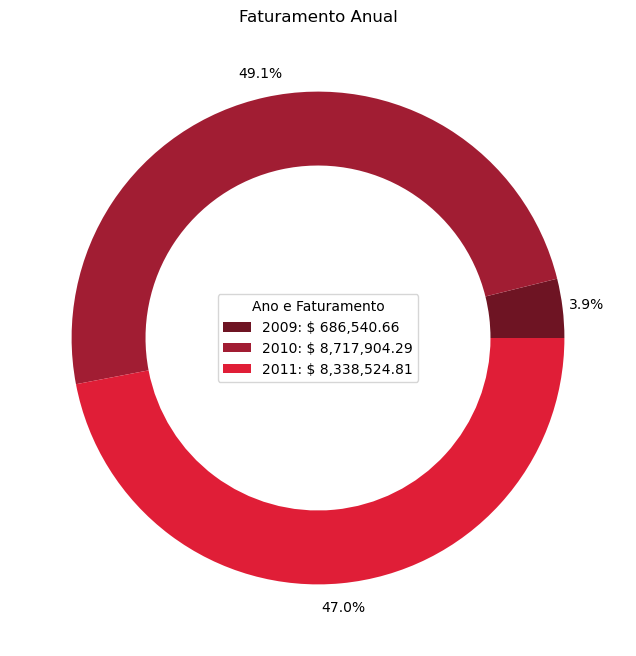

In [173]:
consulta_fat = consulta_sql(banco_dados=acesso_wgift, query=consulta, colunas=colunas)
consulta_fat = consulta_fat.T.reset_index()
consulta_fat = consulta_fat.rename(columns={'index':'Ano',0:'Faturamento'})
grafico_pizza(dados=consulta_fat)

**4. Quantidade Total de produtos vendidos.**

In [319]:
# Consulta SQL
consulta = """
            SELECT SUM(quantidade)
            FROM dimensional.fvendas;"""

In [327]:
produtos_vendidos_quantidade = consulta_sql(banco_dados=acesso_wgift, query=consulta, colunas=[''])
print(f'Quantidade de produtos vendidos no período: {produtos_vendidos_quantidade.iloc[0,0]:,.0f}.')

Quantidade de produtos vendidos no período: 10,720,695.


**5. Os 10 paises com mais clientes fora do Reino Unido**

In [188]:
# Configurações de gráfico
configuracao_grafico = ('Os 10 paises com mais clientes fora do Reino Unido', 'v', 'País', 'Total Vendido')

# Consulta SQL
consulta = """
            SELECT 
                localizacao,
                COUNT(cliente) AS total
            FROM dimensional.dclientes
            GROUP BY localizacao
            ORDER BY total DESC;"""

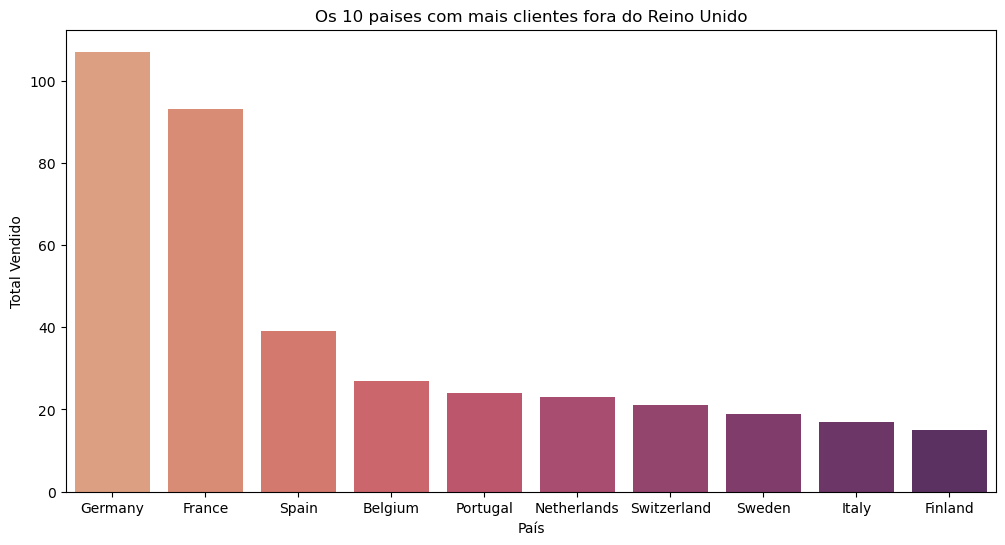

In [192]:
top_10_paises = consulta_sql(banco_dados=acesso_wgift, query=consulta, colunas=configuracao_grafico[2:4])
top_10_paises = top_10_paises[1:11]
grafico_barras(dados=top_10_paises, config_grafico=configuracao_grafico)

**6. Os 10 maiores clientes.**

In [232]:
# Configurações de gráfico
configuracao_grafico = ('Os 10 maiores clientes', 'h', 'Total Vendido', 'Clientes')

# Consulta SQL
consulta = """
            SELECT
                sum(total_vendido) as Total_vendas,
                c.cliente as Clientes
            FROM dimensional.fvendas v
            INNER JOIN dimensional.dclientes c ON v.id_cliente = c.id_cliente
            GROUP BY c.cliente
            ORDER BY Total_vendas DESC
            LIMIT 10;"""

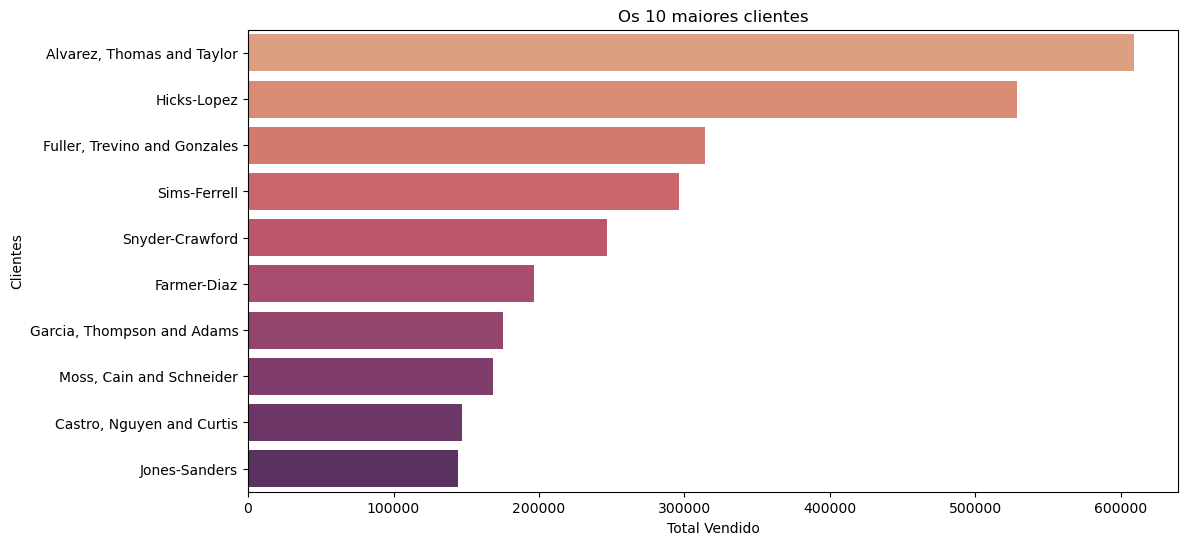

In [233]:
top_5_clientes= consulta_sql(banco_dados=acesso_wgift, query=consulta, colunas=configuracao_grafico[2:4])
grafico_barras(dados=top_5_clientes, config_grafico=configuracao_grafico)

**7. Os 10 produtos mais vendidos.**

In [244]:
# Configurações de gráfico
configuracao_grafico = ('Os 10 produtos mais vendidos', 'h', 'Total', 'Produtos')

# Consulta SQL
consulta = """
            SELECT 
                SUM(quantidade) AS Total,
                p.produto AS Produtos
            FROM dimensional.fvendas v
            INNER JOIN dimensional.dprodutos p ON v.id_produto = p.id_produto
            GROUP BY p.produto
            ORDER BY Total DESC
            LIMIT 10;"""

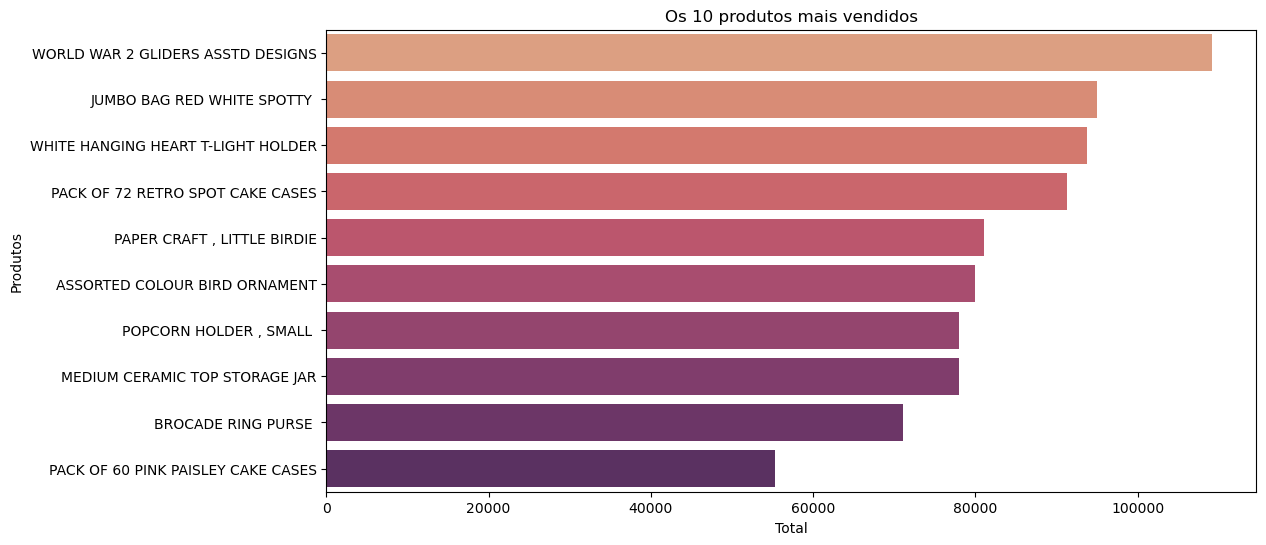

In [245]:
top_5_produtos = consulta_sql(banco_dados=acesso_wgift, query=consulta, colunas=configuracao_grafico[2:4])
grafico_barras(dados=top_5_produtos, config_grafico=configuracao_grafico)

**8. As 10 notas emitidas com maior faturamento**

In [240]:
# Configurações de gráfico
configuracao_grafico = ('As 10 Maiores Notas Faturadas', 'h', 'Faturamento', 'Invoice')

# Consulta SQL
consulta = """
            SELECT 
                SUM(total_vendido) AS total_nota,                
                invoice
            FROM dimensional.fvendas
            GROUP BY invoice, data
            ORDER BY total_nota DESC
            LIMIT 10;"""

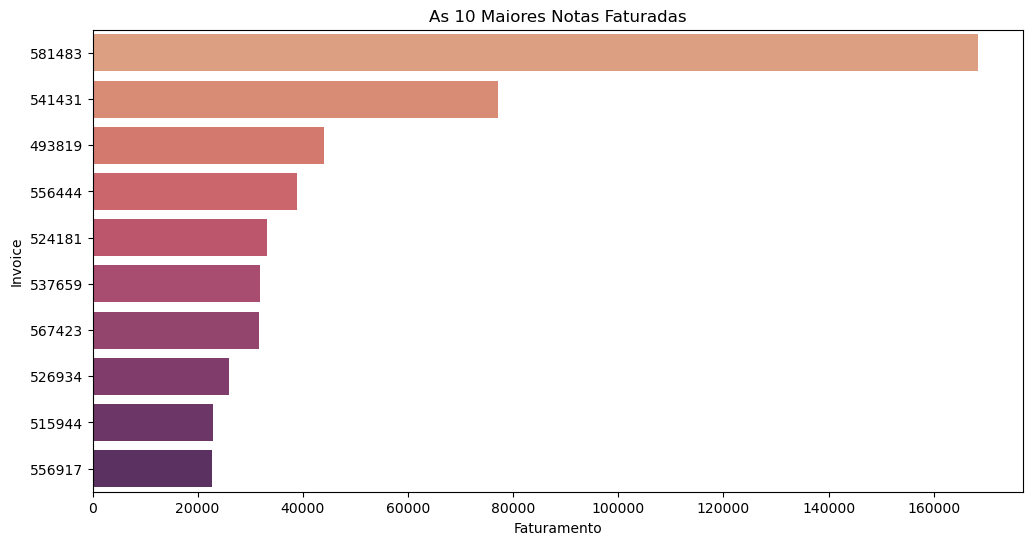

In [241]:
top_5_produtos = consulta_sql(banco_dados=acesso_wgift, query=consulta, colunas=configuracao_grafico[2:4])
grafico_barras(dados=top_5_produtos, config_grafico=configuracao_grafico)

**9. Os 10 paises com mais vendas.**

In [313]:
# Dados de colunas
colunas = ['pais', 'vendas']

# Zoom do mapa
zoom = 2

# Consulta SQL
consulta = """
            SELECT 
                c.localizacao,
                count(invoice) AS Quantidade_vendas
            FROM dimensional.fvendas v
            INNER JOIN dimensional.dclientes c ON v.id_cliente = c.id_cliente
            GROUP BY localizacao
            ORDER BY Quantidade_vendas DESC
            LIMIT 10;"""

In [314]:
vendas_paises = consulta_sql(banco_dados=acesso_wgift, query=consulta, colunas=colunas)
vendas_paises.loc[vendas_paises['pais'].str.contains('Germany'), ['pais']] = 'Alemanha'
grafico_mapa(dados=vendas_paises, zoom=zoom)

# Fim